In [1]:
from google.colab import drive
import os
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive"

In [5]:
!kaggle datasets download -d vishesh1412/celebrity-face-image-dataset
!unzip \*.zip && rm *.zip

Dataset URL: https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset
License(s): CC0-1.0
 93% 49.0M/52.9M [00:00<00:00, 77.6MB/s]
100% 52.9M/52.9M [00:00<00:00, 79.8MB/s]
Archive:  celebrity-face-image-dataset.zip
  inflating: Celebrity Faces Dataset/Angelina Jolie/001_fe3347c0.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/002_8f8da10e.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/003_57612506.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/004_f61e7d0c.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/005_582c121a.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/006_9135205d.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/007_cabbfcbb.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/008_d1f87068.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/009_fb3e6174.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/010_f99d79e3.jpg  
  inflating: Celebrity Faces Dataset/Angelina Jolie/011_734

In [38]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

DATA_DIR = '/content/Celebrity Faces Dataset'

In [39]:
image_size = 64
batch_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [40]:
train_ds = ImageFolder(DATA_DIR, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [41]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
def denorm(img_tensors):
  return img_tensors * stats[1][0] + stats[0][0]

In [43]:
def gorsellestirme(images, nmax = 64):
  fig, ax = plt.subplots(figsize = (8, 8))
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1, 2, 0))

def batch_s(dl, nmax = 64):
  for images, _ in dl:
    gorsellestirme(images, nmax)
    break

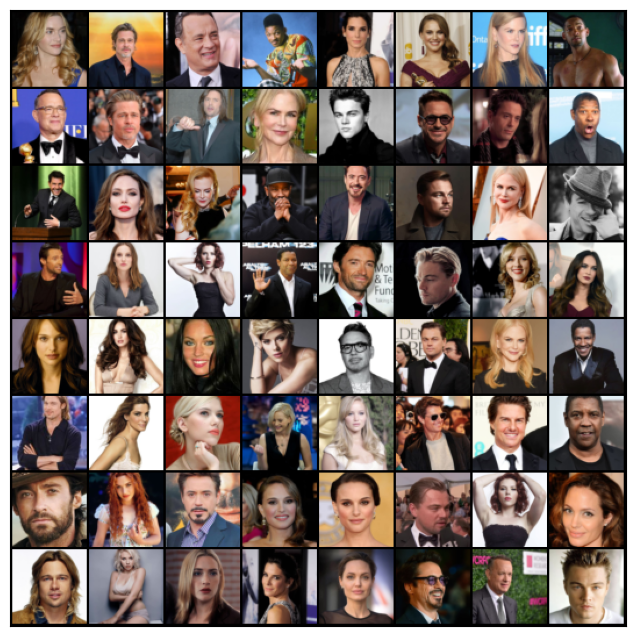

In [44]:
batch_s(train_dl)

In [45]:
def device_0():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dil)

In [46]:
device = device_0()
device

device(type='cuda')

In [47]:
train_dl = DeviceDataLoader(train_dl, device)

In [48]:
import torch.nn as nn

discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace = True),
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [49]:
discriminator = to_device(discriminator, device)

In [50]:
latent_size = 128

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

In [51]:
generator = to_device(generator, device)

In [52]:
def train_ds(real_images, opt_d):
  opt_d.zero_grad()

  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device = device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
  fake_images = generator(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

In [53]:
def train_gen(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [54]:
from torchvision.utils import save_image

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

In [55]:
def save_s(index, latent_tensors, show = True):
  fake_images = generator(latent_tensors)
  fake_fname = 'uretilen-gorsel-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
  print('Kaydedildi -> ', fake_fname)

  if show:
    fig, ax = plt.subplots(figsize = (8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1, 2, 0))

Kaydedildi ->  uretilen-gorsel-0000.png


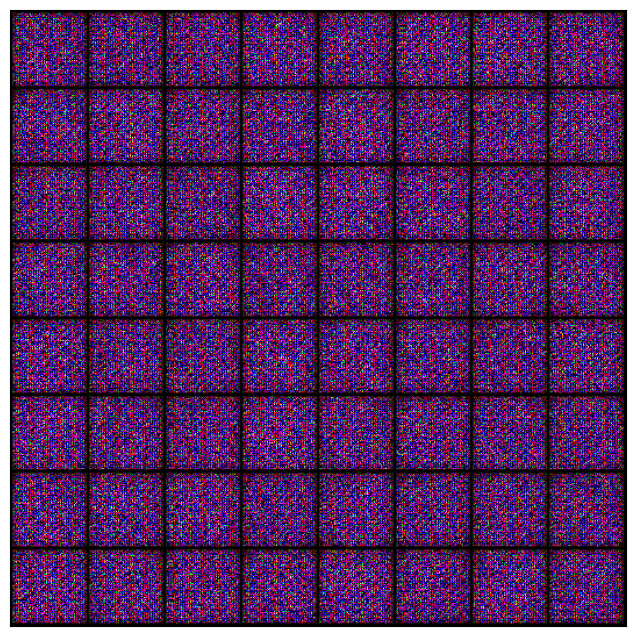

In [56]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

save_s(0, fixed_latent)

In [57]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      loss_d, real_score, fake_score = train_ds(real_images, opt_d)
      loss_g = train_gen(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print(f'Epoch: {epoch + 1}/ {epochs}')

    save_s(epoch + start_idx, fixed_latent, show = False)

  return losses_g, losses_d, real_scores, fake_scores

In [58]:
%%time

lr = 0.005
epochs = 100
history = fit(epochs, lr)

0it [00:00, ?it/s]

Epoch: 1/ 100
Kaydedildi ->  uretilen-gorsel-0001.png


0it [00:00, ?it/s]

Epoch: 2/ 100
Kaydedildi ->  uretilen-gorsel-0002.png


0it [00:00, ?it/s]

Epoch: 3/ 100
Kaydedildi ->  uretilen-gorsel-0003.png


0it [00:00, ?it/s]

Epoch: 4/ 100
Kaydedildi ->  uretilen-gorsel-0004.png


0it [00:00, ?it/s]

Epoch: 5/ 100
Kaydedildi ->  uretilen-gorsel-0005.png


0it [00:00, ?it/s]

Epoch: 6/ 100
Kaydedildi ->  uretilen-gorsel-0006.png


0it [00:00, ?it/s]

Epoch: 7/ 100
Kaydedildi ->  uretilen-gorsel-0007.png


0it [00:00, ?it/s]

Epoch: 8/ 100
Kaydedildi ->  uretilen-gorsel-0008.png


0it [00:00, ?it/s]

Epoch: 9/ 100
Kaydedildi ->  uretilen-gorsel-0009.png


0it [00:00, ?it/s]

Epoch: 10/ 100
Kaydedildi ->  uretilen-gorsel-0010.png


0it [00:00, ?it/s]

Epoch: 11/ 100
Kaydedildi ->  uretilen-gorsel-0011.png


0it [00:00, ?it/s]

Epoch: 12/ 100
Kaydedildi ->  uretilen-gorsel-0012.png


0it [00:00, ?it/s]

Epoch: 13/ 100
Kaydedildi ->  uretilen-gorsel-0013.png


0it [00:00, ?it/s]

Epoch: 14/ 100
Kaydedildi ->  uretilen-gorsel-0014.png


0it [00:00, ?it/s]

Epoch: 15/ 100
Kaydedildi ->  uretilen-gorsel-0015.png


0it [00:00, ?it/s]

Epoch: 16/ 100
Kaydedildi ->  uretilen-gorsel-0016.png


0it [00:00, ?it/s]

Epoch: 17/ 100
Kaydedildi ->  uretilen-gorsel-0017.png


0it [00:00, ?it/s]

Epoch: 18/ 100
Kaydedildi ->  uretilen-gorsel-0018.png


0it [00:00, ?it/s]

Epoch: 19/ 100
Kaydedildi ->  uretilen-gorsel-0019.png


0it [00:00, ?it/s]

Epoch: 20/ 100
Kaydedildi ->  uretilen-gorsel-0020.png


0it [00:00, ?it/s]

Epoch: 21/ 100
Kaydedildi ->  uretilen-gorsel-0021.png


0it [00:00, ?it/s]

Epoch: 22/ 100
Kaydedildi ->  uretilen-gorsel-0022.png


0it [00:00, ?it/s]

Epoch: 23/ 100
Kaydedildi ->  uretilen-gorsel-0023.png


0it [00:00, ?it/s]

Epoch: 24/ 100
Kaydedildi ->  uretilen-gorsel-0024.png


0it [00:00, ?it/s]

Epoch: 25/ 100
Kaydedildi ->  uretilen-gorsel-0025.png


0it [00:00, ?it/s]

Epoch: 26/ 100
Kaydedildi ->  uretilen-gorsel-0026.png


0it [00:00, ?it/s]

Epoch: 27/ 100
Kaydedildi ->  uretilen-gorsel-0027.png


0it [00:00, ?it/s]

Epoch: 28/ 100
Kaydedildi ->  uretilen-gorsel-0028.png


0it [00:00, ?it/s]

Epoch: 29/ 100
Kaydedildi ->  uretilen-gorsel-0029.png


0it [00:00, ?it/s]

Epoch: 30/ 100
Kaydedildi ->  uretilen-gorsel-0030.png


0it [00:00, ?it/s]

Epoch: 31/ 100
Kaydedildi ->  uretilen-gorsel-0031.png


0it [00:00, ?it/s]

Epoch: 32/ 100
Kaydedildi ->  uretilen-gorsel-0032.png


0it [00:00, ?it/s]

Epoch: 33/ 100
Kaydedildi ->  uretilen-gorsel-0033.png


0it [00:00, ?it/s]

Epoch: 34/ 100
Kaydedildi ->  uretilen-gorsel-0034.png


0it [00:00, ?it/s]

Epoch: 35/ 100
Kaydedildi ->  uretilen-gorsel-0035.png


0it [00:00, ?it/s]

Epoch: 36/ 100
Kaydedildi ->  uretilen-gorsel-0036.png


0it [00:00, ?it/s]

Epoch: 37/ 100
Kaydedildi ->  uretilen-gorsel-0037.png


0it [00:00, ?it/s]

Epoch: 38/ 100
Kaydedildi ->  uretilen-gorsel-0038.png


0it [00:00, ?it/s]

Epoch: 39/ 100
Kaydedildi ->  uretilen-gorsel-0039.png


0it [00:00, ?it/s]

Epoch: 40/ 100
Kaydedildi ->  uretilen-gorsel-0040.png


0it [00:00, ?it/s]

Epoch: 41/ 100
Kaydedildi ->  uretilen-gorsel-0041.png


0it [00:00, ?it/s]

Epoch: 42/ 100
Kaydedildi ->  uretilen-gorsel-0042.png


0it [00:00, ?it/s]

Epoch: 43/ 100
Kaydedildi ->  uretilen-gorsel-0043.png


0it [00:00, ?it/s]

Epoch: 44/ 100
Kaydedildi ->  uretilen-gorsel-0044.png


0it [00:00, ?it/s]

Epoch: 45/ 100
Kaydedildi ->  uretilen-gorsel-0045.png


0it [00:00, ?it/s]

Epoch: 46/ 100
Kaydedildi ->  uretilen-gorsel-0046.png


0it [00:00, ?it/s]

Epoch: 47/ 100
Kaydedildi ->  uretilen-gorsel-0047.png


0it [00:00, ?it/s]

Epoch: 48/ 100
Kaydedildi ->  uretilen-gorsel-0048.png


0it [00:00, ?it/s]

Epoch: 49/ 100
Kaydedildi ->  uretilen-gorsel-0049.png


0it [00:00, ?it/s]

Epoch: 50/ 100
Kaydedildi ->  uretilen-gorsel-0050.png


0it [00:00, ?it/s]

Epoch: 51/ 100
Kaydedildi ->  uretilen-gorsel-0051.png


0it [00:00, ?it/s]

Epoch: 52/ 100
Kaydedildi ->  uretilen-gorsel-0052.png


0it [00:00, ?it/s]

Epoch: 53/ 100
Kaydedildi ->  uretilen-gorsel-0053.png


0it [00:00, ?it/s]

Epoch: 54/ 100
Kaydedildi ->  uretilen-gorsel-0054.png


0it [00:00, ?it/s]

Epoch: 55/ 100
Kaydedildi ->  uretilen-gorsel-0055.png


0it [00:00, ?it/s]

Epoch: 56/ 100
Kaydedildi ->  uretilen-gorsel-0056.png


0it [00:00, ?it/s]

Epoch: 57/ 100
Kaydedildi ->  uretilen-gorsel-0057.png


0it [00:00, ?it/s]

Epoch: 58/ 100
Kaydedildi ->  uretilen-gorsel-0058.png


0it [00:00, ?it/s]

Epoch: 59/ 100
Kaydedildi ->  uretilen-gorsel-0059.png


0it [00:00, ?it/s]

Epoch: 60/ 100
Kaydedildi ->  uretilen-gorsel-0060.png


0it [00:00, ?it/s]

Epoch: 61/ 100
Kaydedildi ->  uretilen-gorsel-0061.png


0it [00:00, ?it/s]

Epoch: 62/ 100
Kaydedildi ->  uretilen-gorsel-0062.png


0it [00:00, ?it/s]

Epoch: 63/ 100
Kaydedildi ->  uretilen-gorsel-0063.png


0it [00:00, ?it/s]

Epoch: 64/ 100
Kaydedildi ->  uretilen-gorsel-0064.png


0it [00:00, ?it/s]

Epoch: 65/ 100
Kaydedildi ->  uretilen-gorsel-0065.png


0it [00:00, ?it/s]

Epoch: 66/ 100
Kaydedildi ->  uretilen-gorsel-0066.png


0it [00:00, ?it/s]

Epoch: 67/ 100
Kaydedildi ->  uretilen-gorsel-0067.png


0it [00:00, ?it/s]

Epoch: 68/ 100
Kaydedildi ->  uretilen-gorsel-0068.png


0it [00:00, ?it/s]

Epoch: 69/ 100
Kaydedildi ->  uretilen-gorsel-0069.png


0it [00:00, ?it/s]

Epoch: 70/ 100
Kaydedildi ->  uretilen-gorsel-0070.png


0it [00:00, ?it/s]

Epoch: 71/ 100
Kaydedildi ->  uretilen-gorsel-0071.png


0it [00:00, ?it/s]

Epoch: 72/ 100
Kaydedildi ->  uretilen-gorsel-0072.png


0it [00:00, ?it/s]

Epoch: 73/ 100
Kaydedildi ->  uretilen-gorsel-0073.png


0it [00:00, ?it/s]

Epoch: 74/ 100
Kaydedildi ->  uretilen-gorsel-0074.png


0it [00:00, ?it/s]

Epoch: 75/ 100
Kaydedildi ->  uretilen-gorsel-0075.png


0it [00:00, ?it/s]

Epoch: 76/ 100
Kaydedildi ->  uretilen-gorsel-0076.png


0it [00:00, ?it/s]

Epoch: 77/ 100
Kaydedildi ->  uretilen-gorsel-0077.png


0it [00:00, ?it/s]

Epoch: 78/ 100
Kaydedildi ->  uretilen-gorsel-0078.png


0it [00:00, ?it/s]

Epoch: 79/ 100
Kaydedildi ->  uretilen-gorsel-0079.png


0it [00:00, ?it/s]

Epoch: 80/ 100
Kaydedildi ->  uretilen-gorsel-0080.png


0it [00:00, ?it/s]

Epoch: 81/ 100
Kaydedildi ->  uretilen-gorsel-0081.png


0it [00:00, ?it/s]

Epoch: 82/ 100
Kaydedildi ->  uretilen-gorsel-0082.png


0it [00:00, ?it/s]

Epoch: 83/ 100
Kaydedildi ->  uretilen-gorsel-0083.png


0it [00:00, ?it/s]

Epoch: 84/ 100
Kaydedildi ->  uretilen-gorsel-0084.png


0it [00:00, ?it/s]

Epoch: 85/ 100
Kaydedildi ->  uretilen-gorsel-0085.png


0it [00:00, ?it/s]

Epoch: 86/ 100
Kaydedildi ->  uretilen-gorsel-0086.png


0it [00:00, ?it/s]

Epoch: 87/ 100
Kaydedildi ->  uretilen-gorsel-0087.png


0it [00:00, ?it/s]

Epoch: 88/ 100
Kaydedildi ->  uretilen-gorsel-0088.png


0it [00:00, ?it/s]

Epoch: 89/ 100
Kaydedildi ->  uretilen-gorsel-0089.png


0it [00:00, ?it/s]

Epoch: 90/ 100
Kaydedildi ->  uretilen-gorsel-0090.png


0it [00:00, ?it/s]

Epoch: 91/ 100
Kaydedildi ->  uretilen-gorsel-0091.png


0it [00:00, ?it/s]

Epoch: 92/ 100
Kaydedildi ->  uretilen-gorsel-0092.png


0it [00:00, ?it/s]

Epoch: 93/ 100
Kaydedildi ->  uretilen-gorsel-0093.png


0it [00:00, ?it/s]

Epoch: 94/ 100
Kaydedildi ->  uretilen-gorsel-0094.png


0it [00:00, ?it/s]

Epoch: 95/ 100
Kaydedildi ->  uretilen-gorsel-0095.png


0it [00:00, ?it/s]

Epoch: 96/ 100
Kaydedildi ->  uretilen-gorsel-0096.png


0it [00:00, ?it/s]

Epoch: 97/ 100
Kaydedildi ->  uretilen-gorsel-0097.png


0it [00:00, ?it/s]

Epoch: 98/ 100
Kaydedildi ->  uretilen-gorsel-0098.png


0it [00:00, ?it/s]

Epoch: 99/ 100
Kaydedildi ->  uretilen-gorsel-0099.png


0it [00:00, ?it/s]

Epoch: 100/ 100
Kaydedildi ->  uretilen-gorsel-0100.png
CPU times: user 4min 56s, sys: 15.1 s, total: 5min 11s
Wall time: 14min 11s


In [59]:
losses_g, losses_d, real_scores, fake_scores = history

In [60]:
torch.save(generator.state_dict(), 'Gen.pth')
torch.save(discriminator.state_dict(), 'Dis.pth')

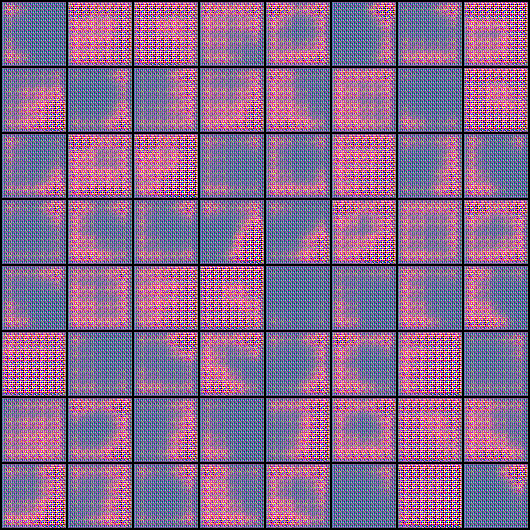

In [65]:
from IPython.display import Image

Image('/content/generated/uretilen-gorsel-0001.png')

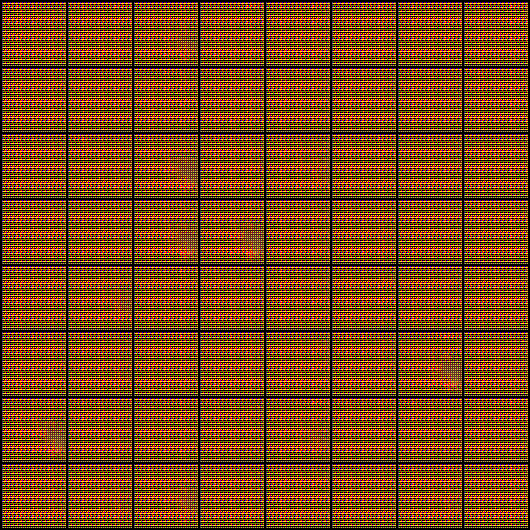

In [66]:
Image('/content/generated/uretilen-gorsel-0025.png')

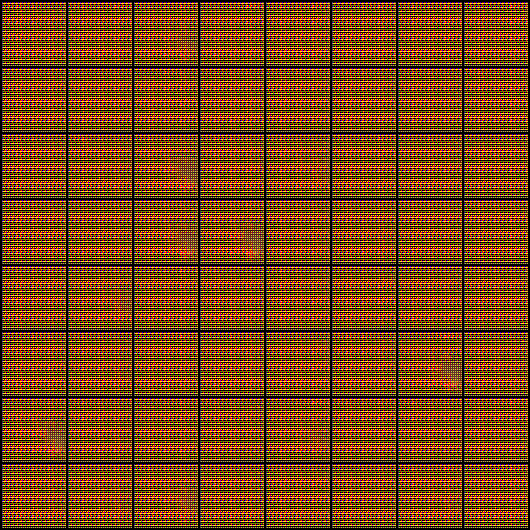

In [67]:
Image('/content/generated/uretilen-gorsel-0074.png')

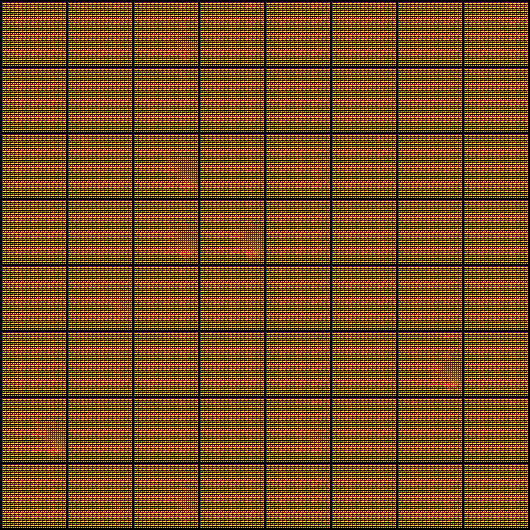

In [68]:
Image('/content/generated/uretilen-gorsel-0100.png')